![](https://mivia.unisa.it/onfire2023/assets/img/iciap_logo.jpg)
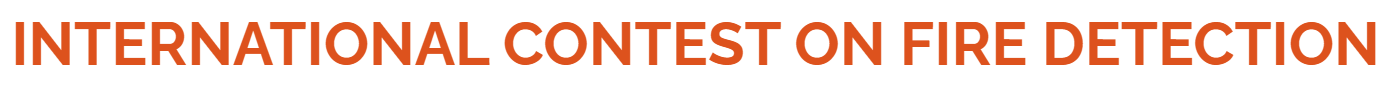

---

Real-time fire detection from image sequences is a highly requested feature in real video surveillance applications, as it can prevent environmental disasters and ensure continuous monitoring of the urban environment and the protection of the forest heritage. In this scenario, there is a great interest to cover the territory with "intelligent cameras" with on board video-analytics algorithms able to detect **fires** (*flames and/or smoke*) in real time, generating immediate notifications for the alarm centers of the competent authorities; these cameras, typically installed in isolated environments, must be self-sufficient from a computational point of view, at most accompanied by a small embedded system that processes the sequence of images by applying the fire detection algorithm. Therefore, very effective methods that require a huge amount of processing resources are useless in this application; it is necessary to find a good trade-off between fire detection accuracy, notification promptness and processing resources.

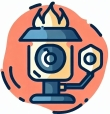

In [ ]:
# Mount your Drive - After doing this step, your Google Drive folders are accessible from Google Colab.
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Download and unzip

The following code blocks are responsible for downloading shared drive files needed for training the model. In particular, the **VIDEOs** are downloaded, from which the frames will be extracted at first and then saved in a .zip file on the drive (**FRAMES**) in order to optimise the time for later times when they are needed. In addition, the **GT** folder, containing the .rtf files of the downloaded videos, is also downloaded. The latter contain the information required for supervised training of the model (Fire and Non-Fire, as well as the second of the start of fire (or smoke) in the video).

In [1]:
import gdown
def download_google_file(shader_url, output_name):
  id_url = "https://drive.google.com/uc?id=" + shader_url.split("/")[5]
  gdown.download(id_url, output_name)

In [ ]:
download_google_file("https://drive.google.com/file/d/1XgE8rAF8TnG_CUWX1Opf2iB2vy5ElspS/view?usp=sharing", "VIDEOS.zip")
!unzip VIDEOS.zip
!rm VIDEOS.zip

In [ ]:
download_google_file("https://drive.google.com/file/d/1Zp-ZViUd34OW1Io8gjYKFh8umbOop0nS/view?usp=sharing", "GT.zip")
!unzip GT.zip
!rm GT.zip

In [ ]:
download_google_file("https://drive.google.com/file/d/1rXMCtpus2i2UDdSBD9RwWAxnT0wrrXOk/view?usp=sharing", "test_code.zip")
!unzip test_code.zip
!rm test_code.zip

In [ ]:
download_google_file("https://drive.google.com/file/d/1y9CB9va4Z965_OCAyQbj9IbOIFpkeK9-/view?usp=sharing", "FRAMES.zip")
!unzip FRAMES.zip -d FRAMES
!rm FRAMES.zip

# We have decided to remove videos 97 to 106 as, upon creating their respective
# frames, we found that they deviated too far from the representation of our
# dataset.
import shutil, os
for i in range(98, 106):
    frame_path_dir = f'FRAMES/TRAINING_SET/0/NewVideo{i}.mp4'
    if os.path.exists(frame_path_dir) and frame_path_dir != "FRAMES/TRAINING_SET/NewVideo105.mp4":
        shutil.rmtree(frame_path_dir)

## Estrazione dei frame dai video

The given code is a Python script that performs video processing tasks using the OpenCV library. Overall, **the code aims to extract frames from video files and save them as individual JPEG images in a designated frames directory**. It also provides options to create a ZIP archive of the frames and move it to a specified location, such as Google Drive. Here's an explanation of what the code does:

1. The function **`fps_from_video(video)`** takes a video file as input, opens the video using OpenCV's `VideoCapture` function, retrieves the frames per second (FPS) value using `cap.get(cv2.CAP_PROP_FPS)`, and returns the FPS value. Before returning, it also releases the video capture object using `cap.release()`.

2. The function **`extract_frames(videos_path, frames_path, zip, url_drive, one_fps)`** is defined.
  - Depending on the `one_fps` flag, the code uses the `os.system` function to execute a command-line instruction with FFmpeg. This instruction extracts frames from the video and saves them as JPEG images in the frames directory. If `one_fps` is True, frames are extracted at a fixed rate of one frame per second using the command `ffmpeg -i {video} -r {fps}/1 {frames_path}/{video}/{frame_number}.jpg`. If `one_fps` is False, the actual FPS of the video is retrieved using the `fps_from_video` function, and frames are extracted accordingly.


In [ ]:
# !rm -rf FRAMES/
# !rm -rf GT

In [ ]:
import cv2, os, argparse, glob, PIL, tqdm, shutil

def fps_from_video(video):
    '''
    Retrieves the frames per second (FPS) value from a video.
    Returns the FPS value if it is less than 10, otherwise returns 10.
    '''
    cap = cv2.VideoCapture(video)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    return fps if fps < 10 else 10

def extract_frames(videos_path = "TRAINING_SET", frames_path = "FRAMES", zip = False, url_drive = '/content/gdrive/MyDrive/ColabNotebooks/ProjectWork', one_fps = False):
    '''
    The function takes several parameters:
        - `videos_path`: The path to the directory containing video files.
        - `frames_path`: The path where extracted frames will be saved.
        - `zip`: A boolean flag indicating whether to create a ZIP archive of the frames folder.
        - `url_drive`: The destination URL for the ZIP archive if `zip` is True.
        - `one_fps`: A boolean flag indicating whether to extract frames at a fixed rate of one frame per second.

    Depending on the `one_fps` flag, the code extracts frames from the video and saves them as JPEG images in the frames directory.
    '''
    # For all the videos
    file_list = [path for path in glob.glob(os.path.join(videos_path,"**"), recursive=True)
                if os.path.isfile(path)]
    # print(file_list)
    for video in tqdm.tqdm(file_list):
        if os.path.isdir(os.path.join(frames_path, video)):
            continue

        os.makedirs(os.path.join(frames_path, video))
        if one_fps:
            os.system("ffmpeg -i {} -r {}/1 {}/{}/{}.jpg".format(video, 1, frames_path, video, "%05d"))
        else:
            fps = fps_from_video(video)
            # print(f'\n\t- Video {video} - fps: {fps}')
            os.system("ffmpeg -i {} -r {}/1 {}/{}/{}.jpg".format(video, fps, frames_path, video, "%05d"))

    if zip:
          # Comprimi la cartella in formato zip
          shutil.make_archive('FRAMES', 'zip', 'FRAMES')

          # Sposta il file zip su Google Drive
          shutil.move('FRAMES.zip', url_drive)

# extract_frames(zip = True, one_fps = False)

Two utility methods are defined:

1. The **`num_frames`** method retrieves the number of frames (FIRE / NON-FIRE) in the FRAMES folder.
2. The **`min_frame_per_video`** method retrieves the minimum number of frames extracted for each video.

In [ ]:
import os

def number_frames():
  frames_total = {}
  for i, label in enumerate(("NON FUOCO", "FUOCO")):
      img = 0
      directory = f'FRAMES/TRAINING_SET/{i}'
      for video in os.listdir(directory):
          path_frames = directory + "/" + video
          frames = os.listdir(path_frames)
          img += len(frames)
      frames_total[label] = img
      print(frames_total)
  return ("FRAMES", sum(frames_total.values()))

total_frames = number_frames()

def min_frame_per_video():
  min = float("inf")
  max = -1
  for i in range(2):
      directory = f'FRAMES/TRAINING_SET/{i}'
      for video in os.listdir(directory):
          path_frames = directory + "/" + video
          frames = os.listdir(path_frames)
          if len(frames) < min:
            min = len(frames)
          else:
            max = len(frames)
  return (min, max)

min_frame = min_frame_per_video()

{'NON FUOCO': 389694}
{'NON FUOCO': 389694, 'FUOCO': 644071}
('FRAMES', 1033765)


(20, 865)

# Splitting Dataset

The code organizes a dataset by splitting it into training, validation, and (optionally) test sets. It shuffles and moves the frames and ground truth data to their respective directories, ensuring that the proportions between the sets are maintained.

The code uses the following proportions for dividing the dataset:

1. If the `test` parameter is set to `False`:
   - Training Set: Approximately 80% of the frames.
   - Validation Set: Approximately 20% of the frames.

2. If the `test` parameter is set to `True`:
   - Training Set: Approximately 70% of the frames.
   - Validation Set: Approximately 20% of the frames.
   - Test Set: Approximately 10% of the frames.

These proportions are calculated based on the total number of frames available in the source directory.

In [4]:
import os
import shutil
import random

def dataset_split(test=False):
    '''
    The code randomly shuffles the folders and assigns them to the respective sets accordingly.
    The purpose of splitting the dataset is to have separate subsets for training, validating, and (optionally) testing machine learning models.
    '''
    # Source and destination directory paths
    frames_source_dir = "FRAMES/TRAINING_SET"
    frames_validation_dir = "FRAMES/VALIDATION_SET"
    gt_source_dir = "GT/TRAINING_SET"
    gt_validation_dir = "GT/VALIDATION_SET"
    if test:
        frames_test_dir = "FRAMES/TEST_SET"
        gt_test_dir = "GT/TEST_SET"

    for i in range(2):
        # Construct paths for source and destination directories
        frames_source_dir_path = os.path.join(frames_source_dir, str(i))
        frames_validation_dir_path = os.path.join(frames_validation_dir, str(i))
        gt_source_dir_path = os.path.join(gt_source_dir, str(i))
        gt_validation_dir_path = os.path.join(gt_validation_dir, str(i))
        os.makedirs(frames_validation_dir_path)
        os.makedirs(gt_validation_dir_path)

        if test:
            frames_test_dir_path = os.path.join(frames_test_dir, str(i))
            gt_test_dir_path = os.path.join(gt_test_dir, str(i))
            os.makedirs(frames_test_dir_path)
            os.makedirs(gt_test_dir_path)

        # Number of items for each dataset set
        num_frames_source_dir = len([f for f in os.listdir(frames_source_dir_path) if os.path.isdir(os.path.join(frames_source_dir_path, f))])
        if test:
            train_len = round(num_frames_source_dir * 0.7)
            val_len = round(num_frames_source_dir * 0.2)
        else:
            train_len = round(num_frames_source_dir * 0.8)
            val_len = round(num_frames_source_dir * 0.2)

        # List of all folders in the source directory
        folders = [f for f in os.listdir(frames_source_dir_path) if os.path.isdir(os.path.join(frames_source_dir_path, f))]

        # Shuffle the list of folders
        random.shuffle(folders)

        # Assign folders for training, validation, and test sets
        train_folders = folders[:train_len]
        val_folders = folders[train_len:train_len+val_len]
        if test:
            test_folders = folders[train_len+val_len:]

        # Move folders from source to validation directory
        for folder in val_folders:
            shutil.move(os.path.join(frames_source_dir_path, folder), os.path.join(frames_validation_dir_path, folder))
            rtf_name = folder.split(".")[0] + ".rtf"
            shutil.move(os.path.join(gt_source_dir_path, rtf_name), gt_validation_dir_path)

        if test:
            # Move folders from source to test directory
            for folder in test_folders:
                shutil.move(os.path.join(frames_source_dir_path, folder), os.path.join(frames_test_dir_path, folder))
                rtf_name = folder.split(".")[0] + ".rtf"
                shutil.move(os.path.join(gt_source_dir_path, rtf_name), gt_test_dir_path)

# Call the dataset_split function with test parameter set to True
dataset_split(test=True)

# PyTorch dataset

![](https://albumentations.ai/assets/img/custom/albumentations_logo.png)

We use [Albumentations](https://albumentations.ai/) to augment a set of frames with the same augmentation parameters.
![](https://albumentations.ai/assets/img/custom/top_image.jpg)

## **VideoFrameDataset**
This script implements a class for managing a video dataset for deep learning. There are mainly two classes:

- **`VideoRecord`**: This class represents the metadata of a single video. It stores information such as the path of the video, the number of frames, the starting frame index, the ending frame index, and the video label. It can handle both single-label classification (one label per video) and multi-label classification (multiple labels per video).

- **`VideoFrameDataset`**: This class extends `torch.utils.data.Dataset` and represents a video dataset. It loads a specified number of frames from each video, uniformly chosen from the beginning to the end of the video. The number of segments to sample and the number of frames per segment can be specified.

  For example, if a video has 120 frames, and `num_segments` is set to 3 and `frames_per_segment` is set to 1, 3 frames will be loaded from the video. If `val_mode` is set to False, the frames will be randomly chosen, approximately evenly distributed along the video. If `val_mode` is set to True, the frames will be chosen exactly at the center of each segment.

- **`ImglistOrdictToTensor`**: This is a helper class that converts a list or dictionary of numpy images into a PyTorch tensor.

The `num_segments` and `frames_per_segment` parameters in the code indicate how frames are selected and loaded from a video into the dataset.

- **num_segments**: This parameter specifies the number of segments into which the video is divided. A segment is a portion of the video from which frames will be sampled. For example, if `num_segments` is set to 3, the video will be divided into 3 segments of equal duration.

- **frames_per_segment**: This parameter indicates the number of frames to be sampled from each segment. For example, if `frames_per_segment` is set to 1, only one frame will be sampled from each segment. If it is set to 3, three consecutive frames will be sampled from each segment.

Therefore, a total of **(num_segments * frames_per_segment) frames** are sampled from the video to create a sample in the dataset. For example, if `num_segments` is 3 and `frames_per_segment` is 1, one frame will be sampled from each of the 3 segments to create a sample.

An important thing to note is that this script uses the **Albumentations** library for image transformations. Albumentations is a fast and flexible image augmentation library that provides a wide range of image augmentation techniques for both 2D and 3D images.

Finally, the code is attempting to open an **`.rtf`** file, read the text inside it, and use this information to determine the video label and starting frame. If the `.rtf` file is empty, then the label is set to 0 and the starting frame is set to 1. If the `.rtf` file is not empty, then the label is set to 1, and the starting frame is the first number in the text read from the file.

The **`strptrf`** class is used to convert an `.rtf` document into a plain text file.

In [5]:
!pip install albumentations
!pip install striprtf

import os, os.path
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
from typing import List, Union, Tuple, Any
from striprtf.striprtf import rtf_to_text
import albumentations, cv2

class VideoRecord(object):
    """
    This class represents the metadata of a video sample. Each VideoRecord object holds
    information such as the video path, the number of frames, the start and end frames, and
    the video label. The methods in this class are mainly properties that return these pieces of information.

    Args:
        **row**: A list with four or more elements where
                 1) The first element is the path to the video frames excluding the root_datapath prefix
                 2) The second element is the start frame ID of the video
                 3) The third element is the inclusive end frame ID of the video
                 4) The fourth element is the label index.
                 5) Any subsequent elements are labels in the case of multi-label classification
        **root_datapath**: The system path to the main video folder.
    """
    def __init__(self, row, root_datapath):
        self._data = row
        self._path = os.path.join(root_datapath, row[0])

    @property
    # This method returns the path of the video
    def path(self) -> str:
        return self._path

    @property
    # This method calculates and returns the total number of frames in the video
    def num_frames(self) -> int:
        return self.end_frame - self.start_frame + 1  # +1 because end frame is inclusive

    @property
    # This method returns the start frame of the video
    def start_frame(self) -> int:
        return int(self._data[1])

    @property
    # This method returns the end frame of the video
    def end_frame(self) -> int:
        return int(self._data[2])

    @property
    # This method returns the label of the video. If the video has multiple labels, it returns a list of labels
    def label(self) -> Union[int, List[int]]:
        # single label_id
        if len(self._data) == 4:
            return int(self._data[3])
        # sample associated with multiple labels
        else:
            return [int(label_id) for label_id in self._data[3:]]

class VideoFrameDataset(torch.utils.data.Dataset):
    """
    A highly efficient and adaptable class for video datasets. Instead of loading every frame of a video, it loads x RGB frames of a video
    (sparse temporal sampling) and uniformly chooses these frames from the start to the end of the video, returning a list of x PIL images or tensors
    of size FRAMES x CHANNELS x HEIGHT x WIDTH.

    Specifically, the frame range [START_FRAME, END_FRAME] is divided into NUM_SEGMENTS segments, and FRAMES_PER_SEGMENT consecutive frames are sampled from each segment.

    Note:
        A demonstration of using this class can be seen in ``demo.py``: https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch
        This dataset broadly corresponds to the frame sampling technique introduced in "Temporal Segment Networks" at ECCV2016 https://arxiv.org/abs/1608.00859.

    Args:
        **root_path**: The root path where the video folders are located. Corresponds to ROOT_DATA from the description above.
        **num_segments**: The number of segments into which the video should be divided to sample frames.
        **frames_per_segment**: The number of frames to be loaded per segment. For each frame interval
                                of a segment, a random start index or the center is chosen, from which the
                                consecutive frames_per_segment frames are loaded.
        **imagefile_template**: The template of the image file name that video frame files
                                have inside their video folders as described above.
        **transform**: Transformation pipeline that takes a list of numpy images/frames.
        **val_mode**: If True, frames are taken from the center of each segment instead of a random position in each segment.

    """
    def __init__(self,
                 root_path: str,
                 num_segments: int = 3,
                 frames_per_segment: int = 1,
                 imagefile_template: str='{:05d}.jpg',
                 transform=None,
                 totensor=True,
                 # Having val_mode = False allows frame sampling at every epoch to have an element of randomness!
                 # Set to True for creating the validation set.
                 test_mode: bool = False):
        super(VideoFrameDataset, self).__init__()

        self.root_path = root_path
        self.num_segments = num_segments
        self.frames_per_segment = frames_per_segment
        self.imagefile_template = imagefile_template
        self.test_mode = test_mode

        if transform is None:
            self.transform = None
        else:
            additional_targets = {}
            for i in range(self.num_segments * self.frames_per_segment - 1):
                additional_targets["image%d" % i] = "image"
            self.transform = albumentations.Compose([transform],
                                                    additional_targets=additional_targets,
                                                    p=1)
        self.totensor = totensor
        self.totensor_transform = ImglistOrdictToTensor()

        self._parse_annotationfile()
        self._sanity_check_samples()

    def _load_image(self, directory: str, idx: int) -> Image.Image:
        """
        This method loads an image from a specific path
        """
        return np.asarray(Image.open(os.path.join(directory, self.imagefile_template.format(idx))).convert('RGB')).copy()

    def _parse_annotationfile(self):
        """
        This method reads the annotation files from the dataset root path. For each video, it creates a VideoRecord object with video information and adds it to the video list.
        """
        self.video_list = []
        for class_name in os.listdir(self.root_path):
            for video_name in os.listdir(os.path.join(self.root_path, class_name)):
                frames_dir = os.path.join(self.root_path, class_name, video_name)
                if os.path.isdir(frames_dir):
                    frame_path = os.path.join(class_name, video_name)
                    end_frame = len(os.listdir(frames_dir))

                    annotation_path = frames_dir \
                        .replace("\\", "/") \
                        .replace("FRAMES/", "GT/") \
                        .replace(".mp4", ".rtf")

                    with open(annotation_path, 'r') as file:
                        text = rtf_to_text(file.read())
                    if len(text):
                        fps = self._fps_from_video(f"TRAINING_SET/{class_name}/{video_name}")
                        label = 1
                        start_frame = int(text.split(",")[0]) * fps
                        if start_frame == 0:
                            start_frame = 1
                    else:
                        label = 0
                        start_frame = 1

                    self.video_list.append(VideoRecord(
                        [frame_path, start_frame, end_frame, label],
                        self.root_path))

    def _sanity_check_samples(self):
        """
        This method checks if the videos in the dataset have enough frames to be divided into segments and that there are no videos with zero frames.
        """
        for record in self.video_list:
            if record.num_frames <= 0 or record.start_frame == record.end_frame:
                print(f"\nDataset Warning: video {record.path} seems to have zero RGB frames on disk!\n")

            elif record.num_frames < (self.num_segments * self.frames_per_segment):
                print(f"\nDataset Warning: video {record.path} has {record.num_frames} frames "
                      f"but the dataloader is set up to load "
                      f"(num_segments={self.num_segments})*(frames_per_segment={self.frames_per_segment})"
                      f"={self.num_segments * self.frames_per_segment} frames. Dataloader will throw an "
                      f"error when trying to load this video.\n")

    def _get_start_indices(self, record: VideoRecord) -> 'np.ndarray[int]':
        """
        This method calculates the start indices for the video segments. If test mode is on, the indices are uniformly distributed throughout the video. Otherwise, the indices are random but approximately equidistant.

        Args:
            record: A VideoRecord denoting a video sample.
        Returns:
            list: Returns a list of indices where the frames of each segment are loaded.
        """
        # choose start indices that are perfectly evenly spread across the video frames.
        if self.test_mode:
            distance_between_indices = (record.num_frames - self.frames_per_segment + 1) / float(self.num_segments)
            start_indices = np.array([int(distance_between_indices / 2.0 + distance_between_indices * x)
                                      for x in range(self.num_segments)])
        # randomly sample start indices that are approximately evenly spread across the video frames.
        else:
            max_valid_start_index = (record.num_frames - self.frames_per_segment + 1) // self.num_segments
            start_indices = np.multiply(list(range(self.num_segments)), max_valid_start_index) + \
                      np.random.randint(max_valid_start_index, size=self.num_segments)

        return start_indices

    def __getitem__(self, idx: int) -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        This method returns a video sample from the dataset, i.e., a set of frames selected from the video. It calculates the start indices for the video segments, then calls _get to obtain the video frames.

        For the video with id **idx**, it loads (self.NUM_SEGMENTS * self.FRAMES_PER_SEGMENT) frames from uniformly chosen positions throughout the video.

        Args:
            idx: Index of the video sample.
        Return:
            A tuple of (video, label). The label is either a single integer or a list of integers in the case of multi-labels. The video is:
                1) A list of PIL images if no transformation is used
                2) A batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1] if the "ImglistToTensor" transformation is used.
                3) Or anything else if a custom transformation is used.
        """
        record: VideoRecord = self.video_list[idx]

        frame_start_indices: 'np.ndarray[int]' = self._get_start_indices(record)

        return self._get(record, frame_start_indices)

    def _get(self, record: VideoRecord, frame_start_indices: 'np.ndarray[int]') -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        This private method loads the frames of a video at the corresponding start indices. For each start index, it loads **frames_per_segment** consecutive frames. If transformation is defined, it applies it to the images. If the **totensor** option is enabled, it transforms the images into PyTorch tensors using the **ImglistOrdictToTensor** transformation.

        Args:
            **record**: A VideoRecord denoting a video sample.
            **frame_start_indices**: Indices from which to load consecutive frames.
        Returns:
            A tuple of (video, label). The label is either a single integer or a list of integers in the case of multi-labels. The video is:
                1) A list of PIL images if no transformation is used
                2) A batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1] if the "ImglistToTensor" transformation is used.
                3) Or anything else if a custom transformation is used.
        """

        frame_start_indices = frame_start_indices + record.start_frame

        images = list()

        # from each start_index, load self.frames_per_segment consecutive frames
        for start_index in frame_start_indices:
            frame_index = int(start_index)

            # load self.frames_per_segment consecutive frames
            for _ in range(self.frames_per_segment):
                image = self._load_image(record.path, frame_index)
                images.append(image)

                if frame_index < record.end_frame:
                    frame_index += 1

        if self.transform is not None:
            transform_input = {"image": images[0]}
            for i, image in enumerate(images[1:]):
                transform_input["image%d" % i] = image
            images = self.transform(**transform_input)

        if self.totensor:
            images = self.totensor_transform(images)
        return images, record.label

    def __len__(self):
        """
        This method returns the number of videos in the dataset
        """
        return len(self.video_list)

    def _fps_from_video(self, video):
        '''
        Retrieves the frames per second (FPS) value from a video.
        Returns the FPS value if it is less than 10, otherwise returns 10.
        '''
        cap = cv2.VideoCapture(video)
        fps = cap.get(cv2.CAP_PROP_FPS)
        cap.release()
        return fps if fps < 10 else 10


class ImglistOrdictToTensor(torch.nn.Module):
    """
    This class converts a list or dictionary of numpy images into a torch.FloatTensor of shape
     (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH). It can be used as the first transformation for VideoFrameDataset.
    """
    @staticmethod
    def forward(img_list_or_dict):
        """
        This method converts each numpy image into a list or dictionary of torch tensors and stacks them into a single tensor.

        Args:
            **img_list_or_dict**: list or dict of numpy images.
        Returns:
            Tensor of size ``NUM_IMAGES x CHANNELS x HEIGHT x WIDTH``
        """
        if isinstance(img_list_or_dict, list):
            return torch.stack([transforms.functional.to_tensor(img)
                                for img in img_list_or_dict])
        else:
            return torch.stack([transforms.functional.to_tensor(img_list_or_dict[k])
                                for k in img_list_or_dict.keys()])

## **Demo Training**

The function **`demo_training`** is used for setting up datasets for training, validation, and testing. Here's a brief explanation:

1. The function imports the necessary libraries and defines the preprocessing step for data augmentation.

2. It sets up the dataset augmentation by creating a random transformation pipeline.

3. It creates the **training dataset** by concatenating two instances of the `VideoFrameDataset` class, each with a different augmentation pipeline. The dataset is configured with the specified root path, number of segments, frames per segment, and the transformation pipeline.

4. It creates the **validation dataset** using the `VideoFrameDataset` class, configured with the specified root path, number of segments, frames per segment, and the preprocessing transformation.

5. If the `test` parameter is set to `True`, it creates the **test dataset** using the `VideoFrameDataset` class, similar to the validation dataset.

In [7]:
from torch.utils.data import ConcatDataset

def demo_training(test = False):
    '''
    The purpose of this code is to set up datasets for training, validation, and testing video-based models,
    applying preprocessing and augmentation techniques to the data.
    '''
    from tqdm import tqdm

    # Preprocessing and augmentation
    preprocessing = albumentations.Sequential([
        albumentations.Resize(height=224, width=224, always_apply=True),
        albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225],
                                 max_pixel_value=255.,
                                 always_apply=True),
    ])

    # Augmentation
    augmentation = albumentations.Compose([
        albumentations.HorizontalFlip(p = .5),                                                      # Horizontal flipping
        albumentations.RandomBrightnessContrast(brightness_limit=(0.8, 1), p = .5),                 # Random brightness variation
        albumentations.GaussianBlur(blur_limit=(3, 7), p = .3),                                     # Gaussian blur
        albumentations.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p = .3)   # Random colour variation
    ], p=.5)

    ## Dataset Augmentation
    # random_transformation = albumentations.Compose([
    #     albumentations.OneOf([
    #         albumentations.HorizontalFlip(),
    #         albumentations.RandomBrightnessContrast(brightness_limit=(0.8, 1)),
    #         albumentations.GaussianBlur(blur_limit=(3, 7)),
    #         albumentations.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    #     ], p=1.0)
    # ])

    # Dataset for training
    training_set = VideoFrameDataset(root_path="FRAMES/TRAINING_SET/",
                                          num_segments=9,
                                          frames_per_segment=2,
                                          transform=albumentations.Compose([
                                              preprocessing,
                                              augmentation],
                                              p=1.,
                                          )
                                    )

    # Dataset for validation
    validation_set = VideoFrameDataset(root_path="FRAMES/VALIDATION_SET/",
                                          num_segments=9,
                                          frames_per_segment=2,
                                          transform=albumentations.Compose([
                                              preprocessing],
                                              p=1.,
                                          ),
                                          test_mode = True
                                      )

    # Dataset for test
    if test:
        test_set = VideoFrameDataset(root_path="FRAMES/TEST_SET/",
                                        num_segments=9,
                                        frames_per_segment=2,
                                        transform=albumentations.Compose([
                                            preprocessing],
                                            p=1.,
                                        ),
                                        test_mode = True
                                    )
    else:
        test_set = []


    return training_set, validation_set, test_set

training_set_4D, validation_set_4D, test_set_4D = demo_training(test = True)

# len(training_set_4D) = 343
# len(validation_set_4D) = 98
# len(test_set_4D) = 50

### Demo Visualization

The function **`demo_visualisation()`** allows you to visualise a subset of the data of a given dataset, passed as an argument.

In [ ]:
def demo_visualization(dataset, counter = float("inf")):
    from torchvision.utils import make_grid
    import matplotlib.pyplot as plt

    for X, y in dataset:
        if counter == 0:
            break
        img = make_grid(X).numpy().transpose((1, 2, 0))
        plt.figure()
        plt.imshow(img)
        plt.title(str(y))
        plt.show()
        counter -= 1

demo_visualization(training_set_4D, counter = 5)

# FireNetAGM

The **"FireNetAGM"** model implemented in the code is specifically designed for the task of fire classification from consecutive frames of a video. The utilization of the different technologies in the model aims to effectively handle the temporal nature of the video data and extract relevant features for accurate fire classification. Here's a brief explanation:

1. **`MobileNetV2`** is employed as the feature extractor because it is a widely used CNN model known for its computational efficiency and accuracy in image feature extraction. In fact, MobileNetV2 is designed to provide efficient and lightweight feature extraction while maintaining a good level of accuracy. T*his makes it well-suited for deployment on resource-constrained devices such as embedded systems and surveillance cameras*. These devices often have limited computational power, memory, and energy resources, making it crucial to have a model that can perform efficiently without sacrificing performance.
By utilizing a pre-trained MobileNetV2 model, the FireNetAGM model can leverage the learned representations from a large dataset, enhancing its ability to capture discriminative features related to fire.

2. **`Batch Normalization (BN)`** is applied to normalize the activations of the MobileNetV2 output. This normalization technique helps in stabilizing and accelerating the training process by reducing internal covariate shift and allowing for better generalization.

3. To handle the temporal dependencies in consecutive video frames, the model incorporates **`LSTM (Long Short-Term Memory)`**, a type of recurrent neural network (RNN) designed to capture long-term dependencies. The LSTM module is utilized to process the sequences of features extracted by MobileNetV2, effectively modeling the temporal context of the video frames and allowing the model to learn the temporal patterns indicative of fire.

4. **`Dropout`** is employed as a regularization technique to prevent overfitting during the training of the LSTM model. By randomly dropping out a proportion of LSTM units during training, dropout helps to improve the model's generalization ability and reduces the risk of overfitting to the training data.

5. A **`linear classifier`** is utilized to classify both individual frames and the entire video sequence. The classifier takes the output of the LSTM module and produces class predictions. Additionally, a sigmoid activation function is applied to the predictions to obtain probability values between 0 and 1, representing the confidence of the model in classifying frames or sequences as fire or non-fire.

The **`forward()`** method in the provided code defines the forward pass of the FireNetAGM model. It takes an input tensor `x` representing a batch of videos, that has dimensions `(batch_size, timesteps, C, H, W)`. The method returns two tensors: **`x_each_frame.squeeze()`** represents the class predictions for each frame, and **`x_prediction.squeeze()`** represents the class prediction for the entire video sequence.

In [32]:
import torch
from torch import nn
from torchvision.models import mobilenet_v2

class FireNetAGM(nn.Module):
    def __init__(self, num_classes=1, lstm_hidden_size = 128, lstm_num_layers = 2, dropout_prob=0.75):
        super(FireNetAGM, self).__init__()

        # Pretrained MobileNetV2 feature extractor
        mobilenet = mobilenet_v2(weights = "DEFAULT")
        self.backbone = nn.Sequential(*list(mobilenet.children())[:-1])

        # Freeze all the layers of the model
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Add Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Batch normalization
        self.bn = nn.BatchNorm1d(1280)

        # LSTM for sequence handling
        self.lstm = nn.LSTM(1280, lstm_hidden_size, lstm_num_layers, batch_first = True)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_prob)

        self.classifier = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        x = x.view(batch_size * timesteps, C, H, W)

        # Feature extraction
        x = self.backbone(x)
        x = self.gap(x)

        # Apply batch normalization
        x = x.view(x.size(0), -1)
        x = self.bn(x)
        x = x.view(batch_size, timesteps, -1)

        # Sequence handling
        x, _ = self.lstm(x)

        # Apply dropout
        x = self.dropout(x)

        # Classification for each frame
        x_each_frame = self.classifier(x)
        x_each_frame = torch.sigmoid(x_each_frame)

        # Classification for the sequence (based on the last frame)
        x_last_frame = self.classifier(x[:, -1, :])

        return x_each_frame.squeeze(), x_last_frame.squeeze()

model = FireNetAGM()
print(model)

FireNetAGM(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), st

## **Training FireNetAGM**

The objective of the provided code is to train the **FireNetAGM** network for fire classification from consecutive video frames. The code implements a dedicated class called **`TrainNet`** to handle the training process.

1. The **`train_epoch`** method performs the training for a single epoch. It iterates over the training data batches, performs forward and backward passes through the model, calculates the loss, and updates the model's parameters using the optimizer. It also computes and logs the training loss and accuracy.

2. The **`val_epoch`** method evaluates the model on the validation set for a single epoch. It sets the model in evaluation mode (`model.eval()`), computes the validation loss and accuracy, and logs them. It also adjusts the scheduler based on the validation loss.

3. The **`fit`** method is the main entry point for training the model. It iterates over the specified number of epochs and calls `train_epoch` and `val_epoch` for each epoch. It keeps track of the best validation loss, performs early stopping if the loss does not improve after a certain number of epochs (controlled by `patience`), and saves the best model based on the validation loss.

In [26]:
from tqdm import tqdm
import torchvision

class TrainNet:
    '''
    Overall, the TrainNet class encapsulates the training process for the FireNetAGM model, including training and validation loops,
    logging of metrics, early stopping, and saving the best model based on the validation loss.
    '''
    def __init__(self, model, train_loader, val_loader, loss_fn, optimizer, scheduler, writer, epochs=100, patience=20):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.writer = writer
        self.epochs = epochs
        self.patience = patience

    def train_epoch(self, epoch):
        self.model.train()
        i_start = epoch * len(self.train_loader)
        for i, (X, y) in enumerate(self.train_loader):
            if i == 0:
                first_frame = X[:, 0]
                writer.add_image('first_batch', torchvision.utils.make_grid(first_frame))

            X = X.cuda()
            y = y.cuda().float()

            self.optimizer.zero_grad()
            o_each_frame, o_prediction = self.model(X)
            loss = self.loss_fn(o_prediction, y)

            loss.backward()
            self.optimizer.step()

            acc = ((o_prediction.detach() > .5) == y.detach()).float().mean()
            self.writer.add_scalar('train/loss', loss.detach().item(), i_start + i)
            self.writer.add_scalar('train/acc', acc, i_start + i)

    def val_epoch(self, epoch):
        self.model.eval()
        val_loss = []
        val_corr_pred = []
        i_start = epoch * len(self.train_loader)
        with torch.no_grad():
            for i, (X, y) in enumerate(self.val_loader):
                X = X.cuda()
                y = y.cuda().float()

                o_each_frame, o_prediction = self.model(X)
                val_loss.append(self.loss_fn(o_prediction, y))
                val_corr_pred.append((o_prediction > .5) == y)

            val_loss = torch.stack(val_loss).mean().item()
            val_accuracy = torch.cat(val_corr_pred).float().mean().item()

            self.scheduler.step(val_loss)

            self.writer.add_scalar('val/loss', val_loss, i_start + i)
            self.writer.add_scalar('val/acc', val_accuracy, i_start + i)
        return val_loss, val_accuracy

    def fit(self):
        best_loss = float('inf')
        counter = 0
        val_losses = torch.zeros(self.epochs)
        val_accuracies = torch.zeros(self.epochs)
        for epoch in tqdm(range(self.epochs)):
            torch.cuda.empty_cache()
            self.train_epoch(epoch)
            val_loss, val_accuracy = self.val_epoch(epoch)

            # Store the validation metrics
            val_losses[epoch] = val_loss
            val_accuracies[epoch] = val_accuracy
            torch.save(val_losses, os.path.join(experiment_name,'val_losses.pth'))
            torch.save(val_accuracies, os.path.join(experiment_name,'val_accuracies.pth'))

            # Save the best model and check the early stopping criteria
            if val_loss < best_loss:
                best_loss = val_loss
                counter = 0                       # Reset early stopping counter
                torch.save(self.model.state_dict(), 'best_model.pth')
                print(f'\n\t- saved best model: Loss = {val_loss}, Accuracy = {val_accuracy}')
            else:
                if epoch > 0 and val_losses[epoch] > val_losses[epoch - 1]:
                    counter += 1
                    print(f'\n\t\t- worsened loss compared to the previous one: val_loss[{epoch}] = {val_losses[epoch]} and counter_early_stopping {counter}')
                    if counter >= self.patience:
                        print('Early stopping...')
                        break
                else:
                    counter = 0
                    print(f'\n\t\t- improved loss compared to the previous one: val_loss[{epoch}] = {val_losses[epoch]} and val_loss[{epoch - 1}] = {val_losses[epoch - 1]}')

#### **Start Tensorboard**

The objective of the provided code is to start **TensorBoard** and create a summary writer for logging training and validation metrics during the execution of the FireNetAGM model.

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook
import os

def start_tensorboard(log_dir):
    writer = SummaryWriter(os.path.join("runs", log_dir))

    # Close the current TensorBoard instance
    !killall tensorboard

    # Load the TensorBoard extension
    %load_ext tensorboard

    # Start TensorBoard with the new log directory
    %tensorboard --logdir ./runs

    notebook.list()  # Display open TensorBoard instances

    return writer

# Create output directory and logger
!rm -rf FireNetAGM/
!rm -rf runs/
i = len(os.listdir("FireNetAGM")) if os.path.exists("FireNetAGM") else 1
experiment_name = f'FireNetAGM/{i}'

os.makedirs(experiment_name)
writer = start_tensorboard(experiment_name)

### **Fitting FireNetAGM**

The following code sets up the data loaders, initializes the model, optimizer, and scheduler, and then trains the model using the TrainNet class, which handles the training and validation loops, loss calculation, and early stopping.

In [ ]:
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torch.nn import BCEWithLogitsLoss
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Train Loader and Val Loader
dataloader_params = {"batch_size": 32, "num_workers": 2, "pin_memory": True}

train_loader = DataLoader(training_set_4D, shuffle=True, **dataloader_params)
val_loader = DataLoader(validation_set_4D, shuffle=False, **dataloader_params)

# Model and TraiNet initialization
torch.cuda.empty_cache()
model = FireNetAGM().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr = .001, weight_decay = 1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode = "min", verbose = True)

trainer = TrainNet(model = model,
                   train_loader = train_loader,
                   val_loader = val_loader,
                   loss_fn = BCEWithLogitsLoss(),
                   optimizer = optimizer,
                   scheduler = scheduler,
                   writer = writer,
                   epochs = 100,
                   patience = 10)

# Fit Net
trainer.fit()

### Download Best-Model and Results

In [ ]:
i = len(os.listdir("FireNetAGM")) if os.path.exists("FireNetAGM") else 1
experiment_name = f'FireNetAGM/{i}'

!mv best_model.pth "FireNetAGM/"$i
!zip -r "FireNetAGM.zip" "FireNetAGM/"$i
from google.colab import files
files.download('FireNetAGM.zip')

## K-Fold-Cross-Validation

The provided code implements **K-fold cross-validation** to train and evaluate a neural network model. `K-fold cross-validation is a technique used to assess the performance and generalization ability of a model`. It involves splitting the dataset into K equal-sized subsets (folds) and performing K iterations of training and evaluation.

In this code, the full dataset (composed of the training and validation sets) is combined into a single ConcatDataset. Then, a KFold object is created with the desired number of splits, K. The KFold object is responsible for generating the train-validation split indices for each fold.

During the iteration over each fold, the train_ids and val_ids are generated by the **`kfold.split()`** method. These indices are used to create Subset objects, train_subsampler and val_subsampler, which represent the training and validation subsets for the current fold.

By applying K-fold cross-validation, this code allows for a more robust assessment of the model's performance by training and evaluating it on different subsets of the data.

**⚠️Important⚠️: Applying k-fold cross-validation, we found a better model compared to the one submitted (loss = 0.19 and accuracy = 0.94). However, Colab halted the code execution due to GPU capacity being exhausted. In an attempt to recover the saved model, especially considering the approaching deadline, we tried unsuccessfully to acquire additional GPUs. Nevertheless, Colab restarted the runtime, resulting in the loss of all locally saved data, including the running model.**

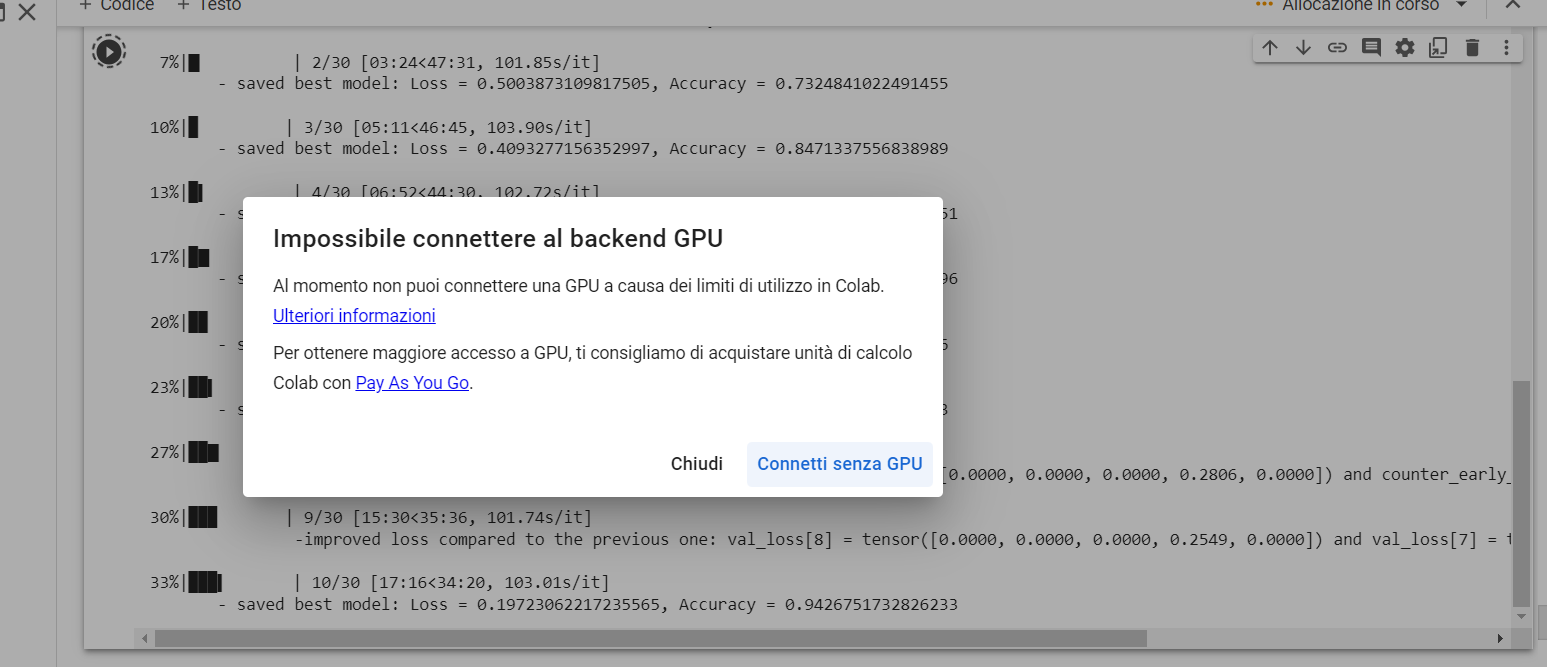

<u>Below is the code that was used in the lost execution</u>.

In [ ]:
# import torch
# from torch import nn
# from torchvision.models import mobilenet_v2

# class FireNetAGM(nn.Module):
#     def __init__(self, num_classes=1, lstm_hidden_size = 64, lstm_num_layers = 2, dropout_prob=0.75):
#         super(FireNetAGM, self).__init__()

#         # Pretrained MobileNetV2 feature extractor
#         mobilenet = mobilenet_v2(weights = "DEFAULT")
#         self.backbone = nn.Sequential(*list(mobilenet.children())[:-1])

#         # Freeze all the layers of the model
#         for param in self.backbone.parameters():
#             param.requires_grad = False

#         # Add Global Average Pooling
#         self.gap = nn.AdaptiveAvgPool2d((1, 1))

#         # Batch normalization
#         self.bn = nn.BatchNorm1d(1280)

#         # LSTM for sequence handling
#         self.lstm = nn.GRU(1280, lstm_hidden_size, lstm_num_layers, batch_first = True)

#         # Dropout for regularization
#         self.dropout = nn.Dropout(dropout_prob)

#         self.classifier = nn.Linear(lstm_hidden_size, num_classes)

#     def forward(self, x):
#         batch_size, timesteps, C, H, W = x.size()
#         x = x.view(batch_size * timesteps, C, H, W)

#         # Feature extraction
#         x = self.backbone(x)
#         x = self.gap(x)

#         # Apply batch normalization
#         x = x.view(x.size(0), -1)
#         x = self.bn(x)
#         x = x.view(batch_size, timesteps, -1)

#         # Sequence handling
#         x, _ = self.lstm(x)

#         # Apply dropout
#         x = self.dropout(x)

#         # Classification for each frame
#         x_each_frame = self.classifier(x)
#         x_each_frame = torch.sigmoid(x_each_frame)

#         # Classification for the sequence (based on the last frame)
#         x_prediction = self.classifier(x[:, -1, :])

#         return x_each_frame.squeeze(), x_prediction.squeeze()

# model = FireNetAGM()
# print(model)

In [ ]:
# from torch.utils.data import DataLoader, Subset, ConcatDataset
# from torch.nn import BCEWithLogitsLoss
# from sklearn.model_selection import KFold
# from tqdm import tqdm

# # Prepare full dataset
# full_dataset = ConcatDataset([training_set_4D, validation_set_4D])

# # Define KFold cross-validator
# K = 5
# kfold = KFold(n_splits = K, shuffle=True)

# # Define dataloader parameters
# dataloader_params = {"batch_size": 32, "num_workers": 2, "pin_memory": True}

# # For each fold...
# for fold, (train_ids, val_ids) in enumerate(tqdm(kfold.split(full_dataset), desc = f'K-Fold-Cross-Validation')):
#     # Define subsets for training and validation data
#     train_subsampler = Subset(full_dataset, train_ids)
#     val_subsampler = Subset(full_dataset, val_ids)

#     # Define data loaders for training and testing data in this fold
#     train_loader = DataLoader(train_subsampler, shuffle=True, **dataloader_params)
#     val_loader = DataLoader(val_subsampler, shuffle=False, **dataloader_params)

#     # Init the neural network, optimizer and trainer
#     torch.cuda.empty_cache()
#     model = FireNetAGM().cuda()
#     optimizer = torch.optim.Adam(model.parameters(), lr = .001, weight_decay = 0)
#     trainer = TrainNet(model = model,
#                        train_loader = train_loader,
#                        val_loader = val_loader,
#                        loss_fn = BCEWithLogitsLoss(),
#                        optimizer = optimizer,
#                        writer = writer,
#                        epochs =30,
#                        patience = 10,
#                        fold = fold)

#     # Fit the model
#     trainer.fit(K)

### **Fitting FireNetAGM**

In [ ]:
# from torch.utils.data import DataLoader, Subset, ConcatDataset
# from torch.nn import BCEWithLogitsLoss
# from sklearn.model_selection import KFold
# from tqdm import tqdm

# # Prepare full dataset
# full_dataset = ConcatDataset([training_set_4D, validation_set_4D])

# # Define KFold cross-validator
# K = 5
# kfold = KFold(n_splits = K, shuffle=True)

# # Define dataloader parameters
# dataloader_params = {"batch_size": 32, "num_workers": 2, "pin_memory": True}

# # For each fold...
# for fold, (train_ids, val_ids) in enumerate(tqdm(kfold.split(full_dataset), desc = f'K-Fold-Cross-Validation')):
#     # Define subsets for training and validation data
#     train_subsampler = Subset(full_dataset, train_ids)
#     val_subsampler = Subset(full_dataset, val_ids)

#     # Define data loaders for training and testing data in this fold
#     train_loader = DataLoader(train_subsampler, shuffle=True, **dataloader_params)
#     val_loader = DataLoader(val_subsampler, shuffle=False, **dataloader_params)

#     # Init the neural network, optimizer and trainer
#     torch.cuda.empty_cache()
#     model = FireNetAGM().cuda()
#     optimizer = torch.optim.Adam(model.parameters(), lr = .001, weight_decay = 0)
#     trainer = TrainNet(model = model,
#                        train_loader = train_loader,
#                        val_loader = val_loader,
#                        loss_fn = BCEWithLogitsLoss(),
#                        optimizer = optimizer,
#                        writer = writer,
#                        epochs =30,
#                        patience = 10,
#                        fold = fold)

#     # Fit the model
#     trainer.fit(K)

## Evaluating the model

The provided code can be used for both the validation and test sets. The metrics calculated, such as accuracy, precision, recall, and F1 score, are applied for evaluating both the validation and test sets.

In the code, the model is loaded with the best weights from the training phase using `torch.load("best_model.pth")`.

Lastly, the code includes the calculation of the ROC curve and the area under the **ROC curve (AUC)**. The ROC curve visualizes the trade-off between the true positive rate and false positive rate for different classification thresholds.

In [ ]:
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluating_model(dataset_4D, display = False):
    # Loading model with the best weights
    model = FireNetAGM().cuda()
    model.load_state_dict(torch.load("best_model.pth"))

    dataloader_params = {"batch_size": 32, "num_workers": 2, "pin_memory": True}
    data_loader = DataLoader(dataset_4D, shuffle=False, **dataloader_params)

    Y, Y_hat = [], []
    with torch.no_grad():
      model.eval()
      for X, y in data_loader:
        Y.append(y)
        o_each_frame, o_prediction = model(X.cuda())
        Y_hat.append((torch.sigmoid(o_prediction) > .5).squeeze().cpu())

    Y = torch.concatenate(Y)
    Y_hat = torch.concatenate(Y_hat)
    print("Validation accuracy:", (Y==Y_hat).float().mean().item())

    # METRICS
    # -------
    accuracy = accuracy_score(Y, Y_hat)
    precision = precision_score(Y, Y_hat)
    recall = recall_score(Y, Y_hat)
    f1 = f1_score(Y, Y_hat)

    print(f'Test Accuracy: {accuracy:.2f}')
    print(f'Test Precision: {precision:.2f}')
    print(f'Test Recall: {recall:.2f}')
    print(f'Test F1 Score: {f1:.2f}')

    # CONFUSION MATRIX
    # ----------------
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    conf_matrix = confusion_matrix(Y, Y_hat)

    sns.heatmap(conf_matrix, annot=True, cmap='flare', fmt='d')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


    # Displaying video frames with prediction
    if display:
        count = 0
        for X, y in enumerate(dataset_4D):
            if count > 5:
                break
            plt.figure()
            plt.imshow(make_grid(X).numpy().transpose((1, 2, 0)))
            plt.title(f'Tag {y} - Prediction {Y_hat[i].float()}')
            plt.show()
            count += 1

    # ROC-CURVE
    # ---------
    from sklearn.metrics import roc_curve, auc

    # Calcola il tasso di vero positivo, il tasso di falso positivo e le soglie
    fpr, tpr, thresholds = roc_curve(Y, Y_hat)

    # Calcola l'area sotto la curva ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Disegna la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    print(f'Area sottesa alla curva ROC {roc_auc}')

evaluating_model(test_set_4D)

## Testing Model from NewVideo

In summary, the code performs video testing for fire detection. It takes a video path as input, loads a pre-trained fire detection model, and applies the model to each frame of the video. **If a fire is detected, the process stops and records the start time of the fire**. It returns a prediction of whether there is a fire in the video and the fire's start time if applicable. Finally, it constructs an HTML block that displays the prediction, plays the video, and provides a descriptive message based on the fire's start time.

In [92]:
!pip install pytube
import pytube

def download_youtube_video(video_url):
    # Create a YouTube object from the video URL.
    youtube = pytube.YouTube(video_url)

    # Get the title of the video.
    title = youtube.title

    # Get the video stream.
    stream = youtube.streams.filter(res="360p").first()

    # Download the video to a file.
    !rm -rf "Youtube/"
    os.makedirs("Youtube")
    stream.download('Youtube', "01.mp4")

download_youtube_video("https://www.youtube.com/watch?v=X4vAxthiJQI")

In [93]:
import cv2, os, argparse, random, albumentations, torch
import numpy as np
from albumentations.pytorch import ToTensorV2

def video_test(video_path, best_model_path = "best_model.pth"):

    # Preprocessing
    preprocessing = albumentations.Sequential([
        albumentations.Resize(height=224, width=224, always_apply=True),
        albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225],
                                max_pixel_value=255.,
                                always_apply=True),
        ToTensorV2(),
    ])

    model = FireNetAGM().cuda()
    model.load_state_dict(torch.load(best_model_path))

    # Set the full path to the video in the format "args.videos/video"
    # path_video = os.path.join(args.videos, video)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    segment_frames = []
    frame_count = 0
    ret, img = cap.read()
    while ret:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            # Convert color space
        tensor_image = preprocessing(image=img)['image']      # Apply transformations
        segment_frames.append(tensor_image.unsqueeze(0))      # Add batch dimension
        frame_count += 1

        # Here you should add your code for applying your method
        if len(segment_frames) == 18:
            with torch.no_grad():
                model.eval()
                X = torch.cat(segment_frames, dim = 0)
                X = X.unsqueeze(0)
                # Predict
                o_each_frame, o_last_frame = model(X.cuda())
                o_last_frame = 1 if torch.sigmoid(o_last_frame) > 0.5 else 0
                if o_last_frame == 1:
                    break
                segment_frames = []

        ret, img = cap.read()

    cap.release()

    fire_start = -1
    with open(video_path.split(".")[0] + ".txt", "w") as f:
          if o_last_frame == 1:
              # Loop over each sequence in the batch
              fire_start_frames = []
              for i, seq in enumerate(o_each_frame, 1):
                  # Find the first frame where the predicted probability of fire is greater than the threshold
                  fire_start = 1 if (seq > 0.5) else 0
                  if fire_start == 1:
                      t = int((frame_count - i) / fps)
                      f.write(str(t))
                      break

    return (o_last_frame, None if fire_start == -1 else t)

prediction, fire_start = video_test("Youtube/01.mp4")

from IPython.display import HTML
from base64 import b64encode
mp4 = open("Youtube/01.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()


if fire_start == -1:
    text = 'The video was labelled "Non-Fire". Therefore, no frame in which fire starts was identified.'
else:
    text = f'The video has been labelled as "Fire". Specifically, the first frame in which fire was detected was at the second {fire_start}.'

HTML("""
        <div>
            <h2>Prediction: {}</h2>
            <div>
                <video width="400" controls>
                    <source src="{}" type="video/mp4">
                </video>
            </div>
            <p>{}</p>
        </div>""".format(prediction, data_url, text))